## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [17]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1_L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [18]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

In [21]:
import itertools

results = {}
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with L1 = 0.010000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/500

50000/50000 [==============================] - 9s 173us/step - loss: 2.4614 - accuracy: 0.0988 - val_loss: 2.4613 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 9s 173us/step - loss: 2.4614 - accuracy: 0.0977 - val_loss: 2.4613 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 9s 172us/step - loss: 2.4614 - accuracy: 0.0982 - val_loss: 2.4611 - val_accuracy: 0.1000
Experiment with L1 = 0.010000, L2 = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________

50000/50000 [==============================] - 9s 175us/step - loss: 2.4626 - accuracy: 0.0971 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 46/50
50000/50000 [==============================] - 9s 172us/step - loss: 2.4626 - accuracy: 0.0971 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 47/50
50000/50000 [==============================] - 9s 176us/step - loss: 2.4626 - accuracy: 0.0981 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 48/50
50000/50000 [==============================] - 9s 177us/step - loss: 2.4626 - accuracy: 0.0982 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 9s 177us/step - loss: 2.4626 - accuracy: 0.0978 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 9s 177us/step - loss: 2.4626 - accuracy: 0.0970 - val_loss: 2.4626 - val_accuracy: 0.1000
Experiment with L1 = 0.010000, L2 = 0.000000
Model: "model_1"
________________________________________________________

50000/50000 [==============================] - 9s 180us/step - loss: 2.4626 - accuracy: 0.0986 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 43/50
50000/50000 [==============================] - 9s 182us/step - loss: 2.4626 - accuracy: 0.0985 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 44/50
50000/50000 [==============================] - 9s 181us/step - loss: 2.4626 - accuracy: 0.0990 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 45/50
50000/50000 [==============================] - 9s 181us/step - loss: 2.4626 - accuracy: 0.0973 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 46/50
50000/50000 [==============================] - 9s 184us/step - loss: 2.4626 - accuracy: 0.0984 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 47/50
50000/50000 [==============================] - 9s 185us/step - loss: 2.4626 - accuracy: 0.0976 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 48/50
50000/50000 [==============================] - 9s 172us/step - loss: 2.4626 - accuracy: 0.0989 - val_loss:

50000/50000 [==============================] - 9s 171us/step - loss: 2.4626 - accuracy: 0.0988 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 40/50
50000/50000 [==============================] - 9s 171us/step - loss: 2.4626 - accuracy: 0.0978 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 41/50
50000/50000 [==============================] - 9s 171us/step - loss: 2.4626 - accuracy: 0.0982 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 42/50
50000/50000 [==============================] - 9s 171us/step - loss: 2.4626 - accuracy: 0.0966 - val_loss: 2.4623 - val_accuracy: 0.1000
Epoch 43/50
50000/50000 [==============================] - 9s 171us/step - loss: 2.4626 - accuracy: 0.0973 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 44/50
50000/50000 [==============================] - 9s 170us/step - loss: 2.4626 - accuracy: 0.0968 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 45/50
50000/50000 [==============================] - 9s 172us/step - loss: 2.4626 - accuracy: 0.0979 - val_loss:

50000/50000 [==============================] - 8s 154us/step - loss: 2.4626 - accuracy: 0.0963 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 37/50
50000/50000 [==============================] - 8s 154us/step - loss: 2.4626 - accuracy: 0.0974 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 38/50
50000/50000 [==============================] - 8s 155us/step - loss: 2.4626 - accuracy: 0.0968 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 39/50
50000/50000 [==============================] - 8s 154us/step - loss: 2.4626 - accuracy: 0.0977 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 40/50
50000/50000 [==============================] - 8s 154us/step - loss: 2.4626 - accuracy: 0.0979 - val_loss: 2.4627 - val_accuracy: 0.1000
Epoch 41/50
50000/50000 [==============================] - 8s 158us/step - loss: 2.4626 - accuracy: 0.0974 - val_loss: 2.4624 - val_accuracy: 0.1000
Epoch 42/50
50000/50000 [==============================] - 8s 156us/step - loss: 2.4626 - accuracy: 0.0964 - val_loss:

50000/50000 [==============================] - 9s 172us/step - loss: 1.8498 - accuracy: 0.4614 - val_loss: 1.8712 - val_accuracy: 0.4517
Epoch 34/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.8381 - accuracy: 0.4643 - val_loss: 1.8460 - val_accuracy: 0.4612
Epoch 35/50
50000/50000 [==============================] - 9s 173us/step - loss: 1.8301 - accuracy: 0.4657 - val_loss: 1.8625 - val_accuracy: 0.4467
Epoch 36/50
50000/50000 [==============================] - 9s 173us/step - loss: 1.8202 - accuracy: 0.4660 - val_loss: 1.8316 - val_accuracy: 0.4643
Epoch 37/50
50000/50000 [==============================] - 9s 172us/step - loss: 1.8131 - accuracy: 0.4676 - val_loss: 1.8367 - val_accuracy: 0.4580
Epoch 38/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.8066 - accuracy: 0.4686 - val_loss: 1.8812 - val_accuracy: 0.4391
Epoch 39/50
50000/50000 [==============================] - 9s 173us/step - loss: 1.7993 - accuracy: 0.4694 - val_loss:

50000/50000 [==============================] - 9s 174us/step - loss: 3.5533 - accuracy: 0.5798 - val_loss: 3.7194 - val_accuracy: 0.5052
Epoch 31/50
50000/50000 [==============================] - 9s 173us/step - loss: 3.4972 - accuracy: 0.5808 - val_loss: 3.6472 - val_accuracy: 0.5214
Epoch 32/50
50000/50000 [==============================] - 9s 174us/step - loss: 3.4425 - accuracy: 0.5843 - val_loss: 3.6086 - val_accuracy: 0.5090
Epoch 33/50
50000/50000 [==============================] - 9s 172us/step - loss: 3.3856 - accuracy: 0.5868 - val_loss: 3.5488 - val_accuracy: 0.5141
Epoch 34/50
50000/50000 [==============================] - 9s 175us/step - loss: 3.3303 - accuracy: 0.5897 - val_loss: 3.4648 - val_accuracy: 0.5334
Epoch 35/50
50000/50000 [==============================] - 9s 175us/step - loss: 3.2809 - accuracy: 0.5913 - val_loss: 3.5465 - val_accuracy: 0.4933
Epoch 36/50
50000/50000 [==============================] - 9s 175us/step - loss: 3.2292 - accuracy: 0.5954 - val_loss:

50000/50000 [==============================] - 9s 175us/step - loss: 3.7234 - accuracy: 0.5681 - val_loss: 3.8245 - val_accuracy: 0.5176
Epoch 28/50
50000/50000 [==============================] - 9s 176us/step - loss: 3.6600 - accuracy: 0.5703 - val_loss: 3.7953 - val_accuracy: 0.5132
Epoch 29/50
50000/50000 [==============================] - 9s 188us/step - loss: 3.6067 - accuracy: 0.5726 - val_loss: 3.7235 - val_accuracy: 0.5245
Epoch 30/50
50000/50000 [==============================] - 9s 179us/step - loss: 3.5498 - accuracy: 0.5782 - val_loss: 3.6588 - val_accuracy: 0.5291
Epoch 31/50
50000/50000 [==============================] - 9s 175us/step - loss: 3.4947 - accuracy: 0.5813 - val_loss: 3.6455 - val_accuracy: 0.5185
Epoch 32/50
50000/50000 [==============================] - 9s 183us/step - loss: 3.4413 - accuracy: 0.5835 - val_loss: 3.5843 - val_accuracy: 0.5207
Epoch 33/50
50000/50000 [==============================] - 9s 179us/step - loss: 3.3929 - accuracy: 0.5825 - val_loss:

50000/50000 [==============================] - 9s 175us/step - loss: 3.9035 - accuracy: 0.5567 - val_loss: 4.0410 - val_accuracy: 0.4981
Epoch 25/50
50000/50000 [==============================] - 9s 174us/step - loss: 3.8397 - accuracy: 0.5626 - val_loss: 3.9251 - val_accuracy: 0.5141
Epoch 26/50
50000/50000 [==============================] - 10s 197us/step - loss: 3.7815 - accuracy: 0.5641 - val_loss: 3.8702 - val_accuracy: 0.5185
Epoch 27/50
50000/50000 [==============================] - 11s 215us/step - loss: 3.7222 - accuracy: 0.5680 - val_loss: 3.8643 - val_accuracy: 0.5062
Epoch 28/50
50000/50000 [==============================] - 10s 197us/step - loss: 3.6664 - accuracy: 0.5697 - val_loss: 3.7889 - val_accuracy: 0.5159
Epoch 29/50
50000/50000 [==============================] - 10s 195us/step - loss: 3.6052 - accuracy: 0.5764 - val_loss: 3.7594 - val_accuracy: 0.5081
Epoch 30/50
50000/50000 [==============================] - 10s 195us/step - loss: 3.5505 - accuracy: 0.5789 - val_

50000/50000 [==============================] - 8s 155us/step - loss: 4.0793 - accuracy: 0.5483 - val_loss: 4.1742 - val_accuracy: 0.4979
Epoch 22/50
50000/50000 [==============================] - 8s 155us/step - loss: 4.0161 - accuracy: 0.5528 - val_loss: 4.1479 - val_accuracy: 0.4947
Epoch 23/50
50000/50000 [==============================] - 8s 155us/step - loss: 3.9542 - accuracy: 0.5560 - val_loss: 4.0758 - val_accuracy: 0.5006
Epoch 24/50
50000/50000 [==============================] - 8s 155us/step - loss: 3.8911 - accuracy: 0.5623 - val_loss: 4.0016 - val_accuracy: 0.5105
Epoch 25/50
50000/50000 [==============================] - 8s 156us/step - loss: 3.8310 - accuracy: 0.5653 - val_loss: 3.9674 - val_accuracy: 0.5062
Epoch 26/50
50000/50000 [==============================] - 8s 156us/step - loss: 3.7693 - accuracy: 0.5705 - val_loss: 3.9067 - val_accuracy: 0.5079
Epoch 27/50
50000/50000 [==============================] - 8s 161us/step - loss: 3.7115 - accuracy: 0.5719 - val_loss:

50000/50000 [==============================] - 12s 236us/step - loss: 2.6112 - accuracy: 0.4670 - val_loss: 2.5532 - val_accuracy: 0.4644
Epoch 19/50
50000/50000 [==============================] - 10s 199us/step - loss: 2.4754 - accuracy: 0.4721 - val_loss: 2.4366 - val_accuracy: 0.4622
Epoch 20/50
50000/50000 [==============================] - 10s 201us/step - loss: 2.3610 - accuracy: 0.4719 - val_loss: 2.3266 - val_accuracy: 0.4685
Epoch 21/50
50000/50000 [==============================] - 11s 220us/step - loss: 2.2616 - accuracy: 0.4769 - val_loss: 2.2427 - val_accuracy: 0.4664
Epoch 22/50
50000/50000 [==============================] - 10s 198us/step - loss: 2.1758 - accuracy: 0.4787 - val_loss: 2.1590 - val_accuracy: 0.4696
Epoch 23/50
50000/50000 [==============================] - 8s 165us/step - loss: 2.1017 - accuracy: 0.4811 - val_loss: 2.0975 - val_accuracy: 0.4689
Epoch 24/50
50000/50000 [==============================] - 8s 165us/step - loss: 2.0376 - accuracy: 0.4832 - val_

50000/50000 [==============================] - 10s 204us/step - loss: 1.5003 - accuracy: 0.5201 - val_loss: 1.5579 - val_accuracy: 0.5037
Epoch 16/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.4820 - accuracy: 0.5267 - val_loss: 1.5535 - val_accuracy: 0.4948
Epoch 17/50
50000/50000 [==============================] - 10s 199us/step - loss: 1.4649 - accuracy: 0.5338 - val_loss: 1.5590 - val_accuracy: 0.4952
Epoch 18/50
50000/50000 [==============================] - 10s 195us/step - loss: 1.4465 - accuracy: 0.5398 - val_loss: 1.5493 - val_accuracy: 0.4995
Epoch 19/50
50000/50000 [==============================] - 10s 191us/step - loss: 1.4294 - accuracy: 0.5462 - val_loss: 1.5456 - val_accuracy: 0.5005
Epoch 20/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.4165 - accuracy: 0.5487 - val_loss: 1.5406 - val_accuracy: 0.4973
Epoch 21/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.4007 - accuracy: 0.5568 - val_

50000/50000 [==============================] - 9s 170us/step - loss: 1.4108 - accuracy: 0.5048 - val_loss: 1.4590 - val_accuracy: 0.4897
Epoch 13/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.3901 - accuracy: 0.5130 - val_loss: 1.4762 - val_accuracy: 0.4793
Epoch 14/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.3709 - accuracy: 0.5190 - val_loss: 1.4389 - val_accuracy: 0.4904
Epoch 15/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.3486 - accuracy: 0.5263 - val_loss: 1.4283 - val_accuracy: 0.4922
Epoch 16/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.3314 - accuracy: 0.5325 - val_loss: 1.4055 - val_accuracy: 0.5020
Epoch 17/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.3147 - accuracy: 0.5389 - val_loss: 1.4054 - val_accuracy: 0.4989
Epoch 18/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.2965 - accuracy: 0.5440 - val_loss:

50000/50000 [==============================] - 10s 199us/step - loss: 1.4999 - accuracy: 0.4743 - val_loss: 1.5129 - val_accuracy: 0.4647
Epoch 10/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.4745 - accuracy: 0.4821 - val_loss: 1.4903 - val_accuracy: 0.4747
Epoch 11/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.4506 - accuracy: 0.4886 - val_loss: 1.4799 - val_accuracy: 0.4705
Epoch 12/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.4283 - accuracy: 0.4969 - val_loss: 1.4656 - val_accuracy: 0.4787
Epoch 13/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.4072 - accuracy: 0.5058 - val_loss: 1.4558 - val_accuracy: 0.4842
Epoch 14/50
50000/50000 [==============================] - 8s 169us/step - loss: 1.3868 - accuracy: 0.5124 - val_loss: 1.4343 - val_accuracy: 0.4865
Epoch 15/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.3654 - accuracy: 0.5195 - val_loss

50000/50000 [==============================] - 8s 167us/step - loss: 1.5875 - accuracy: 0.4433 - val_loss: 1.5871 - val_accuracy: 0.4411
Epoch 7/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.5524 - accuracy: 0.4575 - val_loss: 1.5512 - val_accuracy: 0.4536
Epoch 8/50
50000/50000 [==============================] - 8s 152us/step - loss: 1.5215 - accuracy: 0.4667 - val_loss: 1.5308 - val_accuracy: 0.4570
Epoch 9/50
50000/50000 [==============================] - 8s 161us/step - loss: 1.4941 - accuracy: 0.4748 - val_loss: 1.5120 - val_accuracy: 0.4650
Epoch 10/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.4662 - accuracy: 0.4863 - val_loss: 1.5007 - val_accuracy: 0.4707
Epoch 11/50
50000/50000 [==============================] - 8s 165us/step - loss: 1.4441 - accuracy: 0.4920 - val_loss: 1.4961 - val_accuracy: 0.4700
Epoch 12/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.4211 - accuracy: 0.5010 - val_loss: 1.

50000/50000 [==============================] - 10s 194us/step - loss: 11.3692 - accuracy: 0.3740 - val_loss: 10.6204 - val_accuracy: 0.3770
Epoch 4/50
50000/50000 [==============================] - 10s 194us/step - loss: 9.9522 - accuracy: 0.3899 - val_loss: 9.3109 - val_accuracy: 0.3958
Epoch 5/50
50000/50000 [==============================] - 10s 193us/step - loss: 8.7483 - accuracy: 0.4006 - val_loss: 8.2058 - val_accuracy: 0.4046
Epoch 6/50
50000/50000 [==============================] - 10s 193us/step - loss: 7.7230 - accuracy: 0.4097 - val_loss: 7.2586 - val_accuracy: 0.4185
Epoch 7/50
50000/50000 [==============================] - 10s 194us/step - loss: 6.8484 - accuracy: 0.4154 - val_loss: 6.4565 - val_accuracy: 0.4210
Epoch 8/50
50000/50000 [==============================] - 10s 202us/step - loss: 6.1031 - accuracy: 0.4230 - val_loss: 5.7729 - val_accuracy: 0.4215
Epoch 9/50
50000/50000 [==============================] - 10s 199us/step - loss: 5.4665 - accuracy: 0.4281 - val_lo

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 172us/step - loss: 2.1729 - accuracy: 0.2733 - val_loss: 2.0059 - val_accuracy: 0.3429
Epoch 2/50
50000/50000 [==============================] - 8s 166us/step - loss: 1.9409 - accuracy: 0.3690 - val_loss: 1.8898 - val_accuracy: 0.3825
Epoch 3/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.8551 - accuracy: 0.4005 - val_loss: 1.8329 - val_accuracy: 0.4016
Epoch 4/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.7964 - accuracy: 0.4227 - val_loss: 1.7918 - val_accuracy: 0.4216
Epoch 5/50
50000/50000 [==============================] - 8s 166us/step - loss: 1.7492 - accuracy: 0.4378 - val_loss: 1.7376 - val_accuracy: 0.4396
Epoch 6/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.7085 - accuracy: 0.4508 - val_loss: 1.7208 - val_accuracy: 0.4421
Epoch 7/50
50000/50000 [==============================] - 8s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 173us/step - loss: 2.0163 - accuracy: 0.2793 - val_loss: 1.8570 - val_accuracy: 0.3507
Epoch 2/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.8006 - accuracy: 0.3682 - val_loss: 1.7539 - val_accuracy: 0.3768
Epoch 3/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.7191 - accuracy: 0.3973 - val_loss: 1.6939 - val_accuracy: 0.4034
Epoch 4/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.6625 - accuracy: 0.4173 - val_loss: 1.6400 - val_accuracy: 0.4262
Epoch 5/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.6152 - accuracy: 0.4344 - val_loss: 1.6042 - val_accuracy: 0.4355
Epoch 6/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.5764 - accuracy: 0.4478 - val_loss: 1.5858 - val_accuracy: 0.4432
Epoch 7/50
50000/50000 [==============================] - 8s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 171us/step - loss: 2.0325 - accuracy: 0.2745 - val_loss: 1.8675 - val_accuracy: 0.3478
Epoch 2/50
50000/50000 [==============================] - 8s 165us/step - loss: 1.7970 - accuracy: 0.3702 - val_loss: 1.7456 - val_accuracy: 0.3923
Epoch 3/50
50000/50000 [==============================] - 8s 165us/step - loss: 1.7091 - accuracy: 0.4013 - val_loss: 1.6791 - val_accuracy: 0.4150
Epoch 4/50
50000/50000 [==============================] - 8s 166us/step - loss: 1.6518 - accuracy: 0.4204 - val_loss: 1.6600 - val_accuracy: 0.4116
Epoch 5/50
50000/50000 [==============================] - 8s 165us/step - loss: 1.6069 - accuracy: 0.4345 - val_loss: 1.6043 - val_accuracy: 0.4409
Epoch 6/50
50000/50000 [==============================] - 8s 165us/step - loss: 1.5701 - accuracy: 0.4488 - val_loss: 1.5716 - val_accuracy: 0.4475
Epoch 7/50
50000/50000 [==============================] - 8s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 152us/step - loss: 2.0355 - accuracy: 0.2707 - val_loss: 1.8727 - val_accuracy: 0.3432
Epoch 2/50
50000/50000 [==============================] - 8s 150us/step - loss: 1.8101 - accuracy: 0.3627 - val_loss: 1.7599 - val_accuracy: 0.3841
Epoch 3/50
50000/50000 [==============================] - 7s 149us/step - loss: 1.7263 - accuracy: 0.3949 - val_loss: 1.7116 - val_accuracy: 0.3988
Epoch 4/50
50000/50000 [==============================] - 7s 149us/step - loss: 1.6683 - accuracy: 0.4132 - val_loss: 1.6530 - val_accuracy: 0.4207
Epoch 5/50
50000/50000 [==============================] - 7s 149us/step - loss: 1.6207 - accuracy: 0.4298 - val_loss: 1.6126 - val_accuracy: 0.4343
Epoch 6/50
50000/50000 [==============================] - 7s 148us/step - loss: 1.5812 - accuracy: 0.4436 - val_loss: 1.5766 - val_accuracy: 0.4470
Epoch 7/50
50000/50000 [==============================] - 7s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 150us/step - loss: 15.0807 - accuracy: 0.2677 - val_loss: 13.9526 - val_accuracy: 0.3331
Epoch 2/50
50000/50000 [==============================] - 7s 147us/step - loss: 13.0220 - accuracy: 0.3528 - val_loss: 12.1313 - val_accuracy: 0.3705
Epoch 3/50
50000/50000 [==============================] - 7s 145us/step - loss: 11.3489 - accuracy: 0.3757 - val_loss: 10.5959 - val_accuracy: 0.3935
Epoch 4/50
50000/50000 [==============================] - 7s 145us/step - loss: 9.9343 - accuracy: 0.3917 - val_loss: 9.2975 - val_accuracy: 0.3959
Epoch 5/50
50000/50000 [==============================] - 7s 148us/step - loss: 8.7347 - accuracy: 0.4021 - val_loss: 8.1913 - val_accuracy: 0.4057
Epoch 6/50
50000/50000 [==============================] - 7s 147us/step - loss: 7.7107 - accuracy: 0.4114 - val_loss: 7.2467 - val_accuracy: 0.4132
Epoch 7/50
50000/50000 [==============================] 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 150us/step - loss: 2.1823 - accuracy: 0.2758 - val_loss: 2.0079 - val_accuracy: 0.3438
Epoch 2/50
50000/50000 [==============================] - 7s 146us/step - loss: 1.9453 - accuracy: 0.3659 - val_loss: 1.9024 - val_accuracy: 0.3795
Epoch 3/50
50000/50000 [==============================] - 7s 146us/step - loss: 1.8616 - accuracy: 0.3952 - val_loss: 1.8298 - val_accuracy: 0.4042
Epoch 4/50
50000/50000 [==============================] - 8s 150us/step - loss: 1.7998 - accuracy: 0.4185 - val_loss: 1.7860 - val_accuracy: 0.4200
Epoch 5/50
50000/50000 [==============================] - 7s 145us/step - loss: 1.7530 - accuracy: 0.4341 - val_loss: 1.7474 - val_accuracy: 0.4281
Epoch 6/50
50000/50000 [==============================] - 7s 147us/step - loss: 1.7156 - accuracy: 0.4476 - val_loss: 1.7206 - val_accuracy: 0.4383
Epoch 7/50
50000/50000 [==============================] - 7s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 149us/step - loss: 2.0342 - accuracy: 0.2742 - val_loss: 1.8682 - val_accuracy: 0.3415
Epoch 2/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.8074 - accuracy: 0.3653 - val_loss: 1.7560 - val_accuracy: 0.3747
Epoch 3/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.7193 - accuracy: 0.3963 - val_loss: 1.6888 - val_accuracy: 0.4002
Epoch 4/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.6602 - accuracy: 0.4176 - val_loss: 1.6404 - val_accuracy: 0.4221
Epoch 5/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.6133 - accuracy: 0.4351 - val_loss: 1.6041 - val_accuracy: 0.4316
Epoch 6/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.5758 - accuracy: 0.4480 - val_loss: 1.5751 - val_accuracy: 0.4441
Epoch 7/50
50000/50000 [==============================] - 7s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 149us/step - loss: 2.0384 - accuracy: 0.2675 - val_loss: 1.8759 - val_accuracy: 0.3393
Epoch 2/50
50000/50000 [==============================] - 7s 145us/step - loss: 1.8203 - accuracy: 0.3589 - val_loss: 1.7805 - val_accuracy: 0.3710
Epoch 3/50
50000/50000 [==============================] - 7s 145us/step - loss: 1.7350 - accuracy: 0.3895 - val_loss: 1.7049 - val_accuracy: 0.3993
Epoch 4/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.6740 - accuracy: 0.4114 - val_loss: 1.6573 - val_accuracy: 0.4242
Epoch 5/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.6242 - accuracy: 0.4294 - val_loss: 1.6116 - val_accuracy: 0.4342
Epoch 6/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.5843 - accuracy: 0.4405 - val_loss: 1.5756 - val_accuracy: 0.4450
Epoch 7/50
50000/50000 [==============================] - 7s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 133us/step - loss: 2.0359 - accuracy: 0.2750 - val_loss: 1.8767 - val_accuracy: 0.3388
Epoch 2/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.8103 - accuracy: 0.3641 - val_loss: 1.7636 - val_accuracy: 0.3851
Epoch 3/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.7232 - accuracy: 0.3959 - val_loss: 1.6894 - val_accuracy: 0.4024
Epoch 4/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.6607 - accuracy: 0.4172 - val_loss: 1.6398 - val_accuracy: 0.4218
Epoch 5/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.6123 - accuracy: 0.4341 - val_loss: 1.5959 - val_accuracy: 0.4354
Epoch 6/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.5734 - accuracy: 0.4466 - val_loss: 1.5667 - val_accuracy: 0.4421s: 1
Epoch 7/50
50000/50000 [==============================] - 

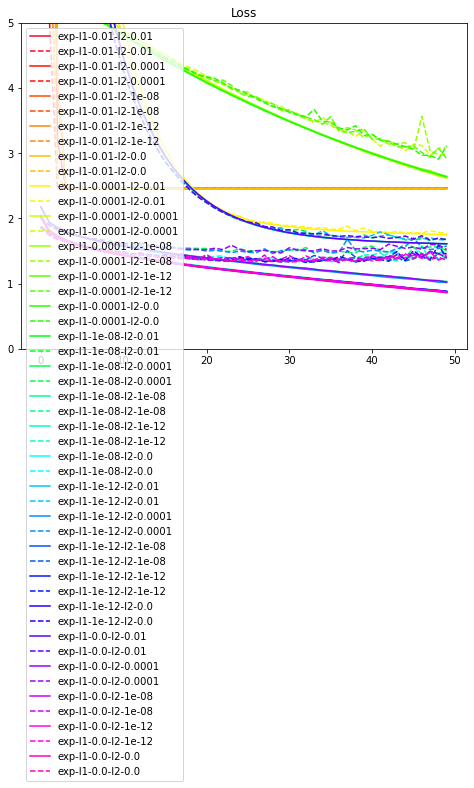

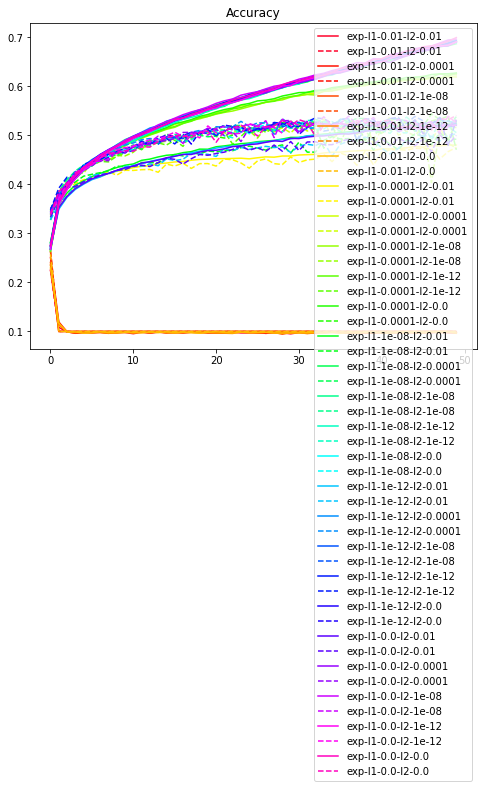

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()